In [1]:
import pandas as pd
import seaborn as sns
import nltk
import re, string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### Sampling

In [4]:
fake_df['label']=0
true_df['label']=1

In [5]:
df = pd.concat([fake_df,true_df])
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
df=df.sample(n=100)

C:\Users\kabuc\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='label'>

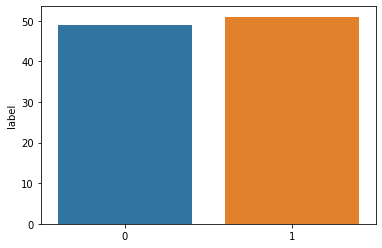

In [7]:
x= df["label"].value_counts()
sns.barplot(x.index,x)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 10656 to 10648
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    100 non-null    object
 1   text     100 non-null    object
 2   subject  100 non-null    object
 3   date     100 non-null    object
 4   label    100 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 4.7+ KB


In [9]:
print(f"Number of duplicates:{df.duplicated().sum()}")

Number of duplicates:0


In [10]:
df = df.drop_duplicates()

In [11]:
df.reset_index(inplace=True)

In [12]:
df.subject.unique()

array(['politics', 'politicsNews', 'worldnews', 'News', 'left-news',
       'Middle-east', 'Government News'], dtype=object)

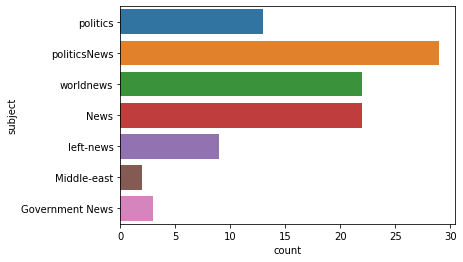

In [13]:
import matplotlib as plt
import seaborn as sns

plot=sns.countplot(y='subject',data= df,orient="h",linewidth=15)

### removing punctuation

In [14]:
import string
string.punctuation
df.head()

,index,title,text,subject,date,label
0,10656,CLASSIC! PRESIDENT TRUMP Totally Rips CNN Repo...,President Trump spoke in the Rose Garden today...,politics,"Jun 10, 2017",0
1,10143,Illinois governor undeterred by court ruling i...,CHICAGO (Reuters) - Illinois Governor Bruce Ra...,politicsNews,"March 29, 2016",1
2,12903,India's Modi fights to protect home base in el...,NEW DELHI (Reuters) - Indian Prime Minister Na...,worldnews,"December 7, 2017",1
3,1936,Republican’s Excuse For Cutting Food Stamps: ...,Republican lawmakers love using the Bible to d...,News,"March 31, 2017",0
4,14492,Factbox - Pot Nation: Canada's plans for legal...,(Reuters) - Recreational marijuana is on track...,worldnews,"November 17, 2017",1


In [15]:
def pre_process(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

### removing stopwords

In [16]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

### lemmatization

In [17]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### tokenize

In [18]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [19]:
def finalpreprocess(string):
    return lemmatizer(stopword(pre_process(string)))
df['clean_text'] = df['text'].apply(lambda x: finalpreprocess(x))
df.head()

,index,title,text,subject,date,label,clean_text
0,10656,CLASSIC! PRESIDENT TRUMP Totally Rips CNN Repo...,President Trump spoke in the Rose Garden today...,politics,"Jun 10, 2017",0,president trump speak rise garden today presse...
1,10143,Illinois governor undeterred by court ruling i...,CHICAGO (Reuters) - Illinois Governor Bruce Ra...,politicsNews,"March 29, 2016",1,chicago reuters illinois governor bruce rauner...
2,12903,India's Modi fights to protect home base in el...,NEW DELHI (Reuters) - Indian Prime Minister Na...,worldnews,"December 7, 2017",1,new delhi reuters indian prime minister narend...
3,1936,Republican’s Excuse For Cutting Food Stamps: ...,Republican lawmakers love using the Bible to d...,News,"March 31, 2017",0,republican lawmaker love use bible dictate pol...
4,14492,Factbox - Pot Nation: Canada's plans for legal...,(Reuters) - Recreational marijuana is on track...,worldnews,"November 17, 2017",1,reuters recreational marijuana track legalize ...


In [20]:
df.to_csv("cleaned.csv")

In [21]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST

X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["label"],test_size=0.2,shuffle=True)

In [22]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

In [23]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
model=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
model.fit(X_train, y_train)  
#Predict y value for test dataset
y_predict = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.91      0.91      0.91        11

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20

Confusion Matrix: [[ 8  1]
 [ 1 10]]
AUC: 0.9393939393939393


In [24]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
model = MultinomialNB()
model.fit(X_train, y_train)  
#Predict y value for test dataset
y_predict = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.77      0.91      0.83        11

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20

Confusion Matrix: [[ 6  3]
 [ 1 10]]
AUC: 0.9696969696969697


In [25]:
# y_pred with DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(f'Error: {zero_one_loss(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

[[ 9  0]
 [ 0 11]]
Error: 0.0
Accuracy: 1.0
